In [1]:
!pip install biopython
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install biopandas -q

In [2]:
import numpy as np
import torch
import pandas as pd
from biopandas.pdb import PandasPdb
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [3]:
from Bio.PDB import DSSP, HSExposureCB, PPBuilder, is_aa, NeighborSearch
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.SeqUtils import seq1
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from timeit import default_timer as timer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score


2024-09-12 16:47:27.108045: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 16:47:27.122303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 16:47:27.139627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 16:47:27.144767: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 16:47:27.157699: I tensorflow/core/platform/cpu_feature_guar

In [5]:
!pip install torch-geometric

Defaulting to user installation because normal site-packages is not writeable


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import os

current_directory = os.getcwd()
path_ring = current_directory + "/data/features_ring/"
path_pdb = current_directory + "/data/pdb_files/"
path_pdb

'/home/noob/BioInfo/protein-structure-classification/data/pdb_files/'

In [6]:
# Combine all PDBs into a single dataframe
dfs = []
for filename in os.listdir(path_ring):
    dfs.append(pd.read_csv(path_ring + filename, sep='\t'))
df = pd.concat(dfs)
df

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,7b5u,A,151,,K,E,0.361,11.0,9.0,-1.975,...,10.0,-1.061,-0.719,H,1.357,-1.453,1.477,0.113,-0.837,NaN
1,7b5u,A,152,,S,E,0.092,7.0,14.0,-1.428,...,12.0,-1.178,2.420,H,-0.228,1.399,-4.760,0.670,-2.647,NaN
2,7b5u,A,156,,L,H,0.030,23.0,4.0,-1.219,...,10.0,-1.472,-0.625,H,0.931,-0.179,-3.005,-0.503,-1.853,NaN
3,7b5u,A,159,,W,H,0.348,17.0,16.0,-0.993,...,22.0,1.340,3.101,L,-0.384,1.652,1.330,1.045,2.064,VDW
4,7b5u,A,197,,E,H,0.747,0.0,20.0,-1.057,...,19.0,-1.061,-0.698,H,-0.591,-1.302,-0.733,1.570,-0.146,HBOND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,2gom,A,137,,V,H,0.014,21.0,16.0,-1.046,...,15.0,-1.078,-0.739,H,1.831,-0.561,0.533,-0.277,1.648,NaN
254,2gom,A,114,,A,H,0.000,22.0,14.0,-1.071,...,14.0,-1.259,-0.601,H,-1.019,-0.987,-1.505,1.266,-0.912,VDW
255,2gom,A,128,,S,H,0.546,3.0,16.0,-1.038,...,19.0,-1.108,-0.777,H,1.538,-0.055,1.502,0.440,2.897,NaN
256,2gom,B,150,,V,H,0.528,5.0,13.0,-1.192,...,11.0,-1.073,-0.744,H,1.538,-0.055,1.502,0.440,2.897,HBOND


In [7]:
df.dropna(inplace=True)
y = df['Interaction'].astype('category')
df

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
3,7b5u,A,159,,W,H,0.348,17.0,16.0,-0.993,...,22.0,1.340,3.101,L,-0.384,1.652,1.330,1.045,2.064,VDW
4,7b5u,A,197,,E,H,0.747,0.0,20.0,-1.057,...,19.0,-1.061,-0.698,H,-0.591,-1.302,-0.733,1.570,-0.146,HBOND
9,7b5u,B,142,,V,-,0.007,22.0,8.0,-1.540,...,10.0,-1.197,2.769,H,1.050,0.302,-3.656,-0.259,-3.242,HBOND
10,7b5u,B,142,,V,-,0.007,22.0,8.0,-1.540,...,10.0,-1.197,2.769,H,1.050,0.302,-3.656,-0.259,-3.242,VDW
12,7b5u,B,165,,T,E,0.134,23.0,24.0,-1.899,...,21.0,-1.867,2.743,H,-1.337,-0.279,-0.544,1.242,-1.262,HBOND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2gom,B,136,,A,H,0.094,20.0,10.0,-1.060,...,8.0,-1.446,-0.168,H,-1.019,-0.987,-1.505,1.266,-0.912,HBOND
251,2gom,A,126,,T,B,0.232,7.0,20.0,-1.547,...,21.0,-1.968,2.705,H,-1.337,-0.279,-0.544,1.242,-1.262,VDW
252,2gom,B,127,,V,H,0.092,10.0,19.0,-1.002,...,24.0,-2.278,2.637,H,-1.337,-0.279,-0.544,1.242,-1.262,HBOND
254,2gom,A,114,,A,H,0.000,22.0,14.0,-1.071,...,14.0,-1.259,-0.601,H,-1.019,-0.987,-1.505,1.266,-0.912,VDW


# Label Encoder Function

In [8]:
label_encoder = LabelEncoder()

def encode_object_columns(df):
    label_encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].astype(str)
            df[column] = label_encoder.fit_transform(df[column])
    return df

# Compute the distances between source residue and target residue using BioPython

In [9]:
from Bio import PDB
import numpy as np
import os
from tqdm import tqdm
from joblib import Parallel, delayed

def get_residue_distance(pdb_id, s_resi, t_resi, s_ch, t_ch, pdb_file_path):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file_path)
    model = structure[0]

    # Locate the source and target chains
    try:
        s_chain = model[s_ch]
        t_chain = model[t_ch]
    except KeyError:
        raise ValueError(f"Chain {s_ch} or {t_ch} not found in structure {pdb_id}")

    # Locate the source and target residues by residue index
    try:
        s_residue = s_chain[s_resi]
        t_residue = t_chain[t_resi]
    except KeyError:
        raise ValueError(f"Residue {s_resi} or {t_resi} not found in chains {s_ch} or {t_ch}")
    try:
        s_ca = s_residue['CA']
        t_ca = t_residue['CA']
    except KeyError:
        raise ValueError(f"Alpha-carbon not found in residue {s_resi} or {t_resi}")
    
    s_ca_coord = s_ca.get_coord()
    t_ca_coord = t_ca.get_coord()

    distance = np.linalg.norm(s_ca_coord - t_ca_coord)

    return distance


def process_row(index, row, pdb_directory):
    pdb_id = row['pdb_id']
    s_resi = row['s_resi']
    t_resi = row['t_resi']
    s_ch = row['s_ch']
    t_ch = row['t_ch']

    pdb_file_path = os.path.join(pdb_directory, f'{pdb_id}.pdb')

    if not os.path.isfile(pdb_file_path):
        print(f"File {pdb_file_path} does not exist.")
        return None

    try:
        # Compute the CA-CA distance
        distance = get_residue_distance(pdb_id, s_resi, t_resi, s_ch, t_ch, pdb_file_path)
        return distance
    except Exception as e:
        print(f"Error processing {pdb_id} (row {index}): {e}")
        return None


def calculate_distances_parallel(df, pdb_directory, n_jobs=-1):
    # Use Parallel to process each row in the dataframe in parallel
    ca_distances = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(index, row, pdb_directory) for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Rows")
    )
    
    # Add the result to the dataframe
    df['CA_CA_distance'] = ca_distances
    return df

if not os.path.exists(current_directory + '/data/df_data.pkl'):
    pdb_directory = path_pdb
    df = calculate_distances_parallel(df, pdb_directory, n_jobs=-1)
else:
    df = pd.read_pickle(current_directory + '/data/df_data.pkl')

df


,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction,CA_CA_distance
0,3m7l,A,123,,R,H,0.032,19.0,10.0,-1.747,...,-1.006,-0.533,H,-1.019,-0.987,-1.505,1.266,-0.912,VDW,6.722287
1,3m7l,A,104,,I,H,0.485,9.0,11.0,-1.124,...,-1.087,-0.709,H,-1.019,-0.987,-1.505,1.266,-0.912,HBOND,6.391156
2,3m7l,A,104,,I,H,0.485,9.0,11.0,-1.124,...,-1.087,-0.709,H,-1.019,-0.987,-1.505,1.266,-0.912,VDW,6.391156
4,3m7l,A,139,,H,-,0.049,20.0,18.0,-2.085,...,-1.033,-0.452,H,-1.006,-0.590,1.891,-0.397,0.412,HBOND,5.929388
5,3m7l,A,139,,H,-,0.049,20.0,18.0,-2.085,...,-1.033,-0.452,H,-1.006,-0.590,1.891,-0.397,0.412,VDW,5.929388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,4a6r,B,400,,I,H,0.101,20.0,13.0,-1.236,...,-0.981,-0.860,H,-1.006,-0.590,1.891,-0.397,0.412,VDW,9.463818
1569,4a6r,A,382,,F,E,0.000,16.0,23.0,-2.681,...,-1.832,2.234,H,-1.239,-0.547,2.131,0.393,0.816,HBOND,5.446033
1570,4a6r,A,266,,G,T,0.000,26.0,24.0,1.706,...,1.784,-0.508,L,-0.384,1.652,1.330,1.045,2.064,HBOND,5.035146
1571,4a6r,B,303,,G,-,0.083,14.0,19.0,-1.338,...,-1.089,-0.757,H,-0.591,-1.302,-0.733,1.570,-0.146,HBOND,5.847882


# Determine Sequence Neighbors

In [ ]:
from Bio import PDB
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import os

def compute_residue_names(pdb_id, s_ch, s_resi, t_ch, t_resi, path_pdb):
    pdb_file = path_pdb + f"{pdb_id}.pdb"
    if not os.path.isfile(pdb_file):
        return None, None, None, None
    
    structure = PDB.PDBParser(QUIET=True).get_structure(pdb_id, pdb_file)

    s_resn_prev, s_resn_next, t_resn_prev, t_resn_next = None, None, None, None
    for model in structure:
        for chain in model:
            for residue in chain:
                if chain.id == s_ch and residue.id[1] == s_resi - 1:
                    s_resn_prev = residue.resname
                if chain.id == s_ch and residue.id[1] == s_resi + 1:
                    s_resn_next = residue.resname
                if chain.id == t_ch and residue.id[1] == t_resi - 1:
                    t_resn_prev = residue.resname
                if chain.id == t_ch and residue.id[1] == t_resi + 1:
                    t_resn_next = residue.resname

    return s_resn_prev, s_resn_next, t_resn_prev, t_resn_next

def process_row(row, path_pdb):
    pdb_id = row['pdb_id']
    s_ch = row['s_ch']
    t_ch = row['t_ch']
    s_resi = row['s_resi']
    t_resi = row['t_resi']

    return compute_residue_names(pdb_id, s_ch, s_resi, t_ch, t_resi, path_pdb)

def process_dataset(df, path_pdb, n_jobs=-1):

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(row, path_pdb) for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Dataset")
    )

    # Extract the results and add them as new columns
    prev_s_resn_list, next_s_resn_list, prev_t_resn_list, next_t_resn_list = zip(*results)

    df['prev_s_resn'] = prev_s_resn_list
    df['next_s_resn'] = next_s_resn_list
    df['prev_t_resn'] = prev_t_resn_list
    df['next_t_resn'] = next_t_resn_list

    return df

df = process_dataset(df, path_pdb)
df

# Determine Neighbors in 3D Space with sequence_separtion=6 

In [10]:
import os
import numpy as np
import pandas as pd
from Bio import PDB
from tqdm import tqdm
from Bio.PDB import PDBParser, NeighborSearch
from joblib import Parallel, delayed

three_to_one_letter = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLU': 'E', 'GLN': 'Q', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

parser = PDB.PDBParser(QUIET=True)

def compute_residue_names(pdb_id, s_ch, s_resi, t_ch, t_resi):

    pdb_file = os.path.join(path_pdb, f'{pdb_id}.pdb')
    structure = parser.get_structure(pdb_id, pdb_file)
    
    source_residue = structure[0][s_ch][s_resi]
    target_residue = structure[0][t_ch][t_resi]
    
    # Get atoms of the source and target residues
    source_atoms = list(source_residue.get_atoms())
    target_atoms = list(target_residue.get_atoms())

    # Create NeighborSearch objects for source and target residues separately
    ns_source = NeighborSearch(source_atoms)
    ns_target = NeighborSearch(target_atoms)

    # Find all residues within 8.0 Å distance from source and target residues
    contacts_source = ns_source.search_all(8.0, level="R")
    contacts_target = ns_target.search_all(8.0, level="R")

    # Combine contacts and remove duplicates
    relevant_contacts = set(contacts_source) | set(contacts_target)

    # Exclude contacts with sequence separation <= 6
    filtered_contacts = []
    for res1, res2 in relevant_contacts:
        res1_id = res1.get_id()[1]  # Residue sequence number
        res2_id = res2.get_id()[1]  # Residue sequence number

        if abs(res1_id - res2_id) > 6:
            filtered_contacts.append((res1, res2))

    # Use the pre-existing source_atoms and target_atoms to extract coordinates
    source_coords = np.array([atom.coord for atom in source_atoms])
    target_coords = np.array([atom.coord for atom in target_atoms])

    min_distance_s, min_distance_t = float('inf'), float('inf')
    s_resn_neighbour, t_resn_neighbour = None, None

    # Process filtered contacts to find the closest residues
    for residue1, residue2 in filtered_contacts:
        if residue1 == target_residue or residue2 == target_residue:
            other_residue = residue2 if residue1 == target_residue else residue1
            other_coords = np.array([atom.coord for atom in other_residue.get_atoms()])
            distances = np.linalg.norm(target_coords[:, np.newaxis] - other_coords, axis=-1)
            min_distance = np.min(distances)

            if min_distance < min_distance_t:
                min_distance_t = min_distance
                t_resn_neighbour = other_residue

        if residue1 == source_residue or residue2 == source_residue:
            other_residue = residue2 if residue1 == source_residue else residue1
            other_coords = np.array([atom.coord for atom in other_residue.get_atoms()])
            distances = np.linalg.norm(source_coords[:, np.newaxis] - other_coords, axis=-1)
            min_distance = np.min(distances)

            if min_distance < min_distance_s:
                min_distance_s = min_distance
                s_resn_neighbour = other_residue

    return (s_resn_neighbour.get_resname() if s_resn_neighbour else None,
            t_resn_neighbour.get_resname() if t_resn_neighbour else None)


def process_row(row):
    pdb_id = row['pdb_id']
    s_ch = row['s_ch']
    t_ch = row['t_ch']
    s_resi = row['s_resi']
    t_resi = row['t_resi']

    s_resn_neighbour, t_resn_neighbour = compute_residue_names(pdb_id, s_ch, s_resi, t_ch, t_resi)
    
    s_resn_neighbour = three_to_one_letter.get(s_resn_neighbour, s_resn_neighbour)
    t_resn_neighbour = three_to_one_letter.get(t_resn_neighbour, t_resn_neighbour)
    
    return s_resn_neighbour, t_resn_neighbour


def process_dataset(df, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(row) for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing rows")
    )

    s_resn_neighbours_list, t_resn_neighbours_list = zip(*results)
    df['s_resn_neighbour'] = s_resn_neighbours_list
    df['t_resn_neighbour'] = t_resn_neighbours_list

    return df

df = process_dataset(df)
df


Processing rows:   2%|▏         | 24904/1471380 [10:33<26:54:35, 14.93it/s]

# Electrostatic Interaction

In [ ]:
one_to_three_letter = {
    'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'D': 'ASP', 'C': 'CYS',
    'E': 'GLU', 'Q': 'GLN', 'G': 'GLY', 'H': 'HIS', 'I': 'ILE',
    'L': 'LEU', 'K': 'LYS', 'M': 'MET', 'F': 'PHE', 'P': 'PRO',
    'S': 'SER', 'T': 'THR', 'W': 'TRP', 'Y': 'TYR', 'V': 'VAL'
}

def get_residue_charge(resn):
    charges = {'ASP': -1, 'GLU': -1, 'LYS': 1, 'ARG': 1, 'HIS': 1}
    return charges.get(resn, 0)  # Default to 0 for neutral residues

def compute_electrostatic_energy(q1, q2, r, epsilon=4.0):
    """Calculates electrostatic energy using Coulomb's Law"""
    k_e = 8.9875 * 10**9  # Coulomb constant in N·m²/C²
    return (k_e * q1 * q2) / (epsilon * r)

def compute_interaction(s_resn, t_resn, distance):
    """Computes electrostatic interaction energy using separate parameters"""
    # Convert one-letter codes to three-letter codes
    s_resn_three = one_to_three_letter.get(s_resn, None)
    t_resn_three = one_to_three_letter.get(t_resn, None)

    if s_resn_three is None or t_resn_three is None:
        print(f"Invalid residue code: {s_resn} or {t_resn}")
        return None

    # Get residue charges
    q1 = get_residue_charge(s_resn_three)
    q2 = get_residue_charge(t_resn_three)

    if distance is None or distance == 0:
        print(f"Distance error for residue pair: {s_resn} - {t_resn}")
        return None

    # Compute electrostatic interaction energy
    return compute_electrostatic_energy(q1, q2, distance)

computed_energies = []

# Loop through each row in the df
for index, row in df.iterrows():
    distance = row['CA_CA_distance']
    energy = compute_interaction(row['s_resn'], row['t_resn'], distance)
    computed_energies.append(energy)
df['electrostatic_energy'] = computed_energies

KeyError: 'CA_CA_distance'

In [ ]:
#Let's transform the data, s.t. all features are numerical
label_encoder = LabelEncoder()

def encode_object_columns(df):
    label_encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].astype(str)
            df[column] = label_encoder.fit_transform(df[column])
    return df

df = encode_object_columns(df)

print(df)

     pdb_id  s_ch  s_resi  s_ins  s_resn  s_ss8  s_rsa  s_up  s_down  s_phi  \
0       922     0      37      0      15      2  0.077  13.0    10.0 -2.562   
1       922     0     108      0       9      4  0.780   2.0    17.0 -1.194   
4       922     0      61      0      17      2  0.000  24.0    15.0 -2.582   
5       922     0      70      0      14      4  0.056  13.0    22.0 -1.005   
8       922     0      87      0       0      3  0.651  10.0    13.0 -1.013   
..      ...   ...     ...    ...     ...    ...    ...   ...     ...    ...   
499     966     0      19      0      19      4  0.000  22.0    12.0 -0.923   
500     966     0      19      0      19      4  0.000  22.0    12.0 -0.923   
501     966     0     108      0      13      2  0.010  20.0    19.0 -2.471   
502     966     0     110      0       4      2  0.015  19.0    16.0 -2.285   
503     966     0       8      0      10      4  0.000  18.0    12.0 -1.114   

     ...  t_down  t_phi  t_psi  t_ss3   t_a1   t_a2

In [ ]:
X = df.drop(columns=['Interaction'])
y = df['Interaction']
# One-hot encode the labels if they are not already
y = to_categorical(y, num_classes=10)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

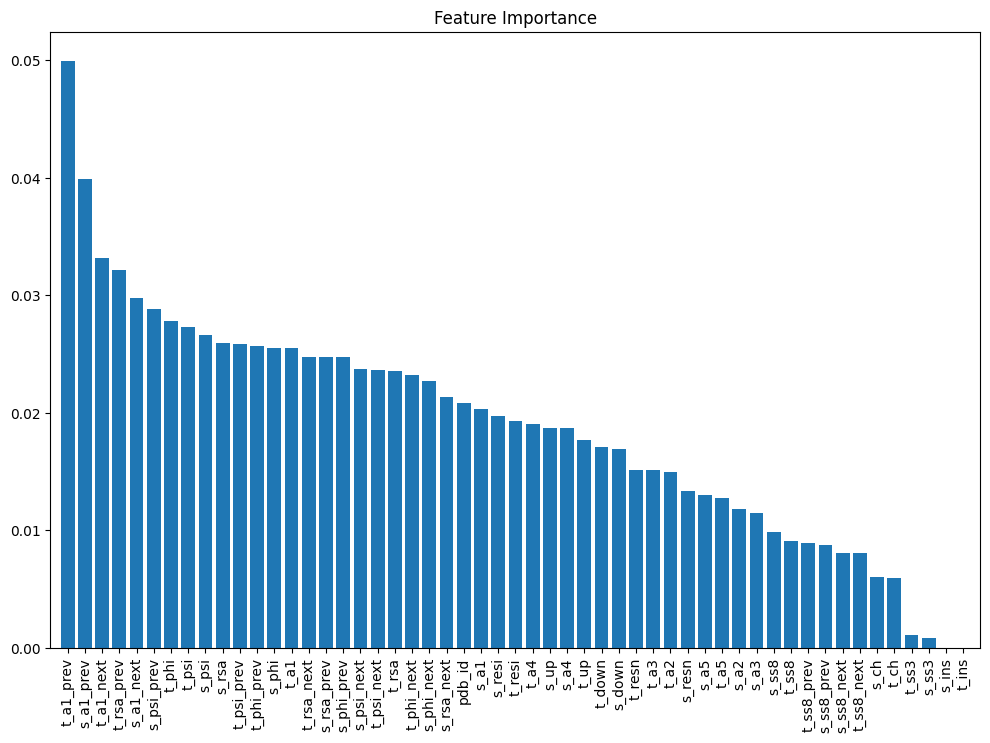

In [ ]:
# Let's check how important are our features
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample a subset of the data
sample_size = 50000  # can be adjusted
df_sample = df.sample(n=sample_size, random_state=42)

X_sample = df_sample.drop(columns=['Interaction'])
y_sample = df_sample['Interaction']

# Convert labels to one-hot encoding if necessary and then back to labels for Random Forest
y_sample = pd.get_dummies(y_sample)  # One-hot encode if needed
y_sample_labels = y_sample.values.argmax(axis=1)  # Convert back to labels

rf = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)  # Reduced parameters
rf.fit(X_sample, y_sample_labels)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importance")
plt.bar(range(X_sample.shape[1]), importances[indices], align="center")
plt.xticks(range(X_sample.shape[1]), X_sample.columns[indices], rotation=90)
plt.xlim([-1, X_sample.shape[1]])
plt.show()


In [ ]:
X = df.drop(columns=['Interaction', 't_ss3', "s_ss3", "t_ins", "s_ins" ])
y = df['Interaction']  # Labels
# One-hot encode the labels if they are not already
y = to_categorical(y, num_classes=10)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Handling imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

model = Sequential()

# Input layer and first hidden layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Second hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Third hidden layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Fourth hidden layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define K-Fold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store scores for each fold
fold_accuracies = []

# K-Fold Cross Validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Create a new model instance for each fold
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold,
                        validation_data=(X_val_fold, y_val_fold),
                        epochs=50,
                        batch_size=32,
                        class_weight=class_weight_dict,
                        callbacks=[early_stopping],
                        verbose=0)  # Set verbose to 1 for detailed output

   # Predict the labels for the validation fold
    y_val_pred = np.argmax(model.predict(X_val_fold), axis=1)
    y_val_true = np.argmax(y_val_fold, axis=1)

    # Compute balanced accuracy for the current fold
    balanced_acc = balanced_accuracy_score(y_val_true, y_val_pred)
    print(f"Balanced accuracy for current fold: {balanced_acc:.4f}")

    fold_accuracies.append(balanced_acc)

# Calculate and print the average balanced accuracy across all folds
average_balanced_accuracy = np.mean(fold_accuracies)
print(f"Average balanced accuracy across all folds: {average_balanced_accuracy:.4f}")


3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Balanced accuracy for current fold: 0.7609
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Balanced accuracy for current fold: 0.7656
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Balanced accuracy for current fold: 0.7707
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Balanced accuracy for current fold: 0.7830
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Balanced accuracy for current fold: 0.7634


In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = np.argmax(y_test, axis=1)

mcc = matthews_corrcoef(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
avg_precision = average_precision_score(y_test, y_pred_proba, average='macro')

print(f"Test accuracy: {test_acc:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")


9197/9197 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
Test accuracy: 0.8098
Matthews Correlation Coefficient: 0.6454
Balanced Accuracy: 0.6038
Average Precision Score: 0.4825


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
